# 章節 8：觀察者偏誤（Observer Bias）

## 8.2 等待時間

- 等待時間稱作 y ，代表到一位到車站的乘客與下一班火車到達的時間。
- 經過時間稱作 x ，代表一位到車站的乘客與與上一班火車離開的時間。

用上述定義則 zb = x + y。

給定 zb 班距分佈，我們可以計算 y 分佈。這邊開始一個簡單的例子然後普遍襪。假設 zb 班距只有 1/3 機率 5 分鐘，與 2/3 機率 10 分鐘。如果我們隨機抵達一個 5 分鐘班距內，y 是從 0 到 5 分鐘之間的均勻分佈。如果我們隨機抵達一個 10 分鐘班距內，y 是從 0 到 10 分鐘之間的均勻分佈。所以整體的分佈是一個以班距加權的均勻分佈混合體。下面函數用 zb 班距分佈產生等待時間分佈 y：

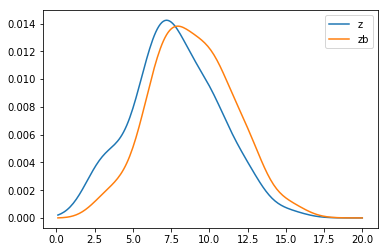

真實資料 z 平均值： 7.774838266350817
乘客偏差資料 zb 平均值： 8.89676868776294


In [102]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import thinkbayes as tb

OBSERVED_GAP_TIMES = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]


def plot_dist(dist):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y)

class TruthGaps(tb.Pmf):
    
    def __init__(self, gaps, x=np.linspace(0.1, 20, 200)):
        super().__init__(x)
        self.kde = gaussian_kde(gaps_min)
        self.make_pmf(x)
        
    def make_pmf(self, x):
        for interval in x:
            self.Set(interval, self.evaluate(interval))
        
        self.Normalize()
        

    def evaluate(self, x):
        return self.kde(x)[0]
            
gaps_min = np.array(OBSERVED_GAP_TIMES)/60.0
z = TruthGaps(gaps_min)


def BiasPmf(pmf):
    # pmf 是真實資料的分佈
    new_pmf = pmf.Copy()
    
    # 在迴圈裡面，我們對每個數值的機率乘上數值本身，x，也就是被觀察到的可能性與 x 成正比
    for x, p in pmf.Items():
        new_pmf.Mult(x, x)
        
    # 正規化
    new_pmf.Normalize()
    
    #new_pmf 是乘客偏差的分佈
    return new_pmf


zb = BiasPmf(z)

plot_dist(z)
plot_dist(zb)
plt.legend(["z", "zb"])
plt.show()
print("真實資料 z 平均值：", z.Mean())
print("乘客偏差資料 zb 平均值：", zb.Mean())

In [103]:
def MakeRange(low, high):
    sec = range(low, int(high*60)+1) # 每秒
    return np.array(sec)/60


def MakeUniformPmf(low, high):
    # low, high 為均勻分佈的範圍（包含兩端點）
    pmf = tb.Pmf()
    for x in MakeRange(low, high): # 產生所有可能的時間數值（分鐘）
        pmf.Set(x, 1)
    
    pmf.Normalize()
    return pmf


def PmfOfWaitTime(pmf_zb):
    
    # metapmf 將每個均勻分佈對應其班距的機率
    metapmf = tb.Pmf()
    for gap, prob in pmf_zb.Items():
        uniform = MakeUniformPmf(0, gap) # 產生均勻分佈
        metapmf.Set(uniform, prob)
    
    # 在 5.6 小節看到，用 MakeMixture 計算混合體
    pmf_y = tb.MakeMixture(metapmf)
        
    return pmf_y

為了封裝計算這些分佈的計算，建立了一個 WaitTimeCalculator 類別：

In [104]:
class WaitTimeCalculator(object):
    
    def __init__(self, pmf_z):
        # pmf_z 是真實班距的分佈
        self.pmf_z = pmf_z
        
        # pmf_zb 是觀察者偏誤的班距分佈
        self.pmf_zb = BiasPmf(pmf_z)
        
        # pmf_y 是等待時間的分佈
        self.pmf_y = PmfOfWaitTime(self.pmf_zb)
        
        # pmf_y 是經過時間的分佈，跟等待時間分佈等同
        self.pmf_x = self.pmf_y

為何 pmf_x 等於 pmf_y？因為對 zb 一特定班距 zp，分佈 y 是 0 到 zp 的均勻分佈。又 x = zp - y ，所以分佈 x 也是從 0 到 zp 的均勻分佈。

下圖為 z, zb 和 y 的根據紅線資料產生的 CDF。

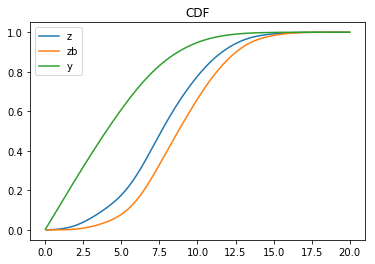

In [105]:
wait_time = WaitTimeCalculator(z)
plot_dist(wait_time.pmf_z.MakeCdf())
plot_dist(wait_time.pmf_zb.MakeCdf())
plot_dist(wait_time.pmf_y.MakeCdf())
plt.title("CDF")
plt.legend(["z", "zb", "y"])
plt.show()

為了顯示這些分佈，這邊用 CDF 表示而非 PMF。大多數人較熟悉 PMF，但是作者認為 CDF 較容易詮釋資料，一但你習慣它們之後。並且如果你要將很多分佈在同一座標上做圖，CDF 是好的選擇。

下圖用 PMF 作圖，請讀者感覺比較一下。

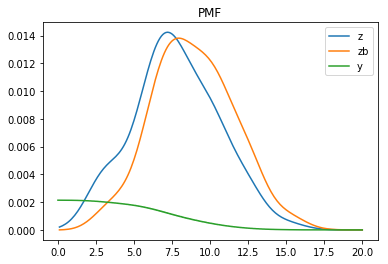

In [106]:
plot_dist(wait_time.pmf_z)
plot_dist(wait_time.pmf_zb)
plot_dist(wait_time.pmf_y)
plt.title("PMF")
plt.legend(["z", "zb", "y"])
plt.show()

In [107]:
print("真實區間分佈 z 平均值：", wait_time.pmf_z.Mean())
print("觀察者偏差區間分佈 zb 平均值：", wait_time.pmf_zb.Mean())
print("等待時間分佈 y 平均值：", wait_time.pmf_y.Mean())

真實區間分佈 z 平均值： 7.774838266350817
觀察者偏差區間分佈 zb 平均值： 8.89676868776294
等待時間分佈 y 平均值： 4.441885686327284


y 的平均值大約是 zb 平均值的一半。 zb 平均值大約比 z 高 13%。

除此之外，紅線的車次表顯示在尖峰時每 9 分鐘一班火車，這很接近 zb 的平均，但是高於 z 的平均。

因此作者與馬薩諸塞州灣運輸局的代表通信詢問後，他們故意是提出較保守的車距，是為了考量不確定的因素。